In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import Counter

### 1. Loading the data: NIPS papers. 
***
The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

In [2]:
# Read data into papers
papers = pd.read_csv('drive/My Drive/papers.csv')
# Remove redundant cols
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)
# See what we have
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


### 2. Removing punctuation and lower-casing

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

### 3. EDA

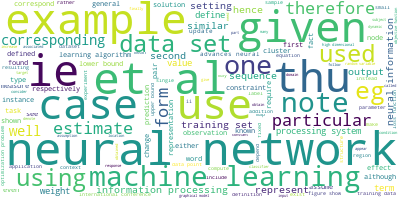

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### 4. CountVectorizer and top-10 frequent words

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


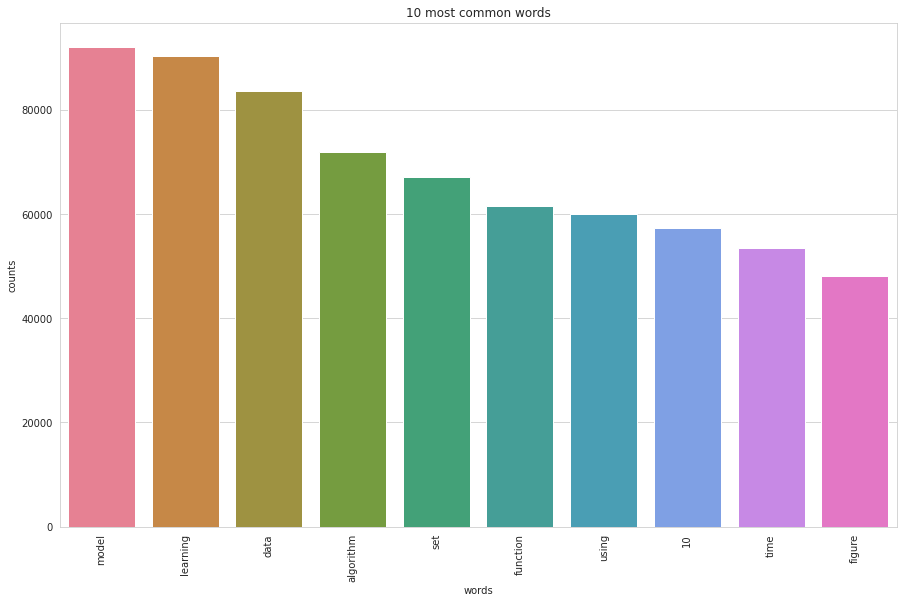

In [5]:
# Load the library with the CountVectorizer method and plotting libs
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### 5. LDA alpha :)

In [6]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
algorithm state learning time policy function value problem optimal action

Topic #1:
network model neural input figure time networks learning output layer

Topic #2:
matrix algorithm data 10 problem log function method methods sparse

Topic #3:
model data models set using learning algorithm distribution number 10

Topic #4:
learning function set error algorithm training data loss let examples


### 6. Tf-IDF Vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

paper_data = papers['paper_text_processed']

n_features = 1000
n_components = 5
n_top_words = 10


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(paper_data)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(paper_data)
print("done in %0.3fs." % (time() - t0))
print()


Extracting tf-idf features for NMF...
done in 17.720s.
Extracting tf features for LDA...
done in 18.385s.



### 7. NMF

In [11]:
# helper
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features")
t0 = time()
nmf = NMF(n_components=number_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features")
t0 = time()
nmf = NMF(n_components=number_topics, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features
done in 4.133s.

Topics in NMF model (Frobenius norm):
Topic #0: algorithm learning kernel matrix xi problem function theorem data convex
Topic #1: network neurons neural input networks neuron units output layer time
Topic #2: policy action state reward actions agent learning reinforcement regret states
Topic #3: model data models distribution inference posterior bayesian latent gaussian likelihood
Topic #4: image images object features feature objects training recognition visual model

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features
done in 19.266s.

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: data algorithm learning function matrix 10 error problem number xi
Topic #1: network neurons neural input networks units neuron output layer spike
Topic #2: policy state regret action learning reward xt algorithm reinforcement agent
Topic #3: model models distribution pos

### 8. LDA again, beta :)

In [12]:
print("Fitting LDA models with tf features, ")
lda = LatentDirichletAllocation(n_components=number_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting LDA models with tf features, 
done in 50.035s.

Topics in LDA model:
Topic #0: algorithm learning state time function policy value xt optimal problem
Topic #1: model data models distribution 10 gaussian matrix log inference algorithm
Topic #2: network neural input time model networks figure neurons output learning
Topic #3: training image learning model features images data feature network object
Topic #4: algorithm learning function problem data matrix 10 error theorem xi

